# PCA, ICA, VQ

Thomas Breuel

In [3]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")

from torchmore import flex
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import linalg as LA

device = "cuda:0" if torch.cuda.is_available() else "cpu"

from tutlib.pcaica import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [31]:
train_ds = list(datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor()))
images = np.array([x[0].view(-1).numpy() for x in train_ds])
classes = np.array([x[1] for x in train_ds])
assert np.amax(images) <= 1.0
assert np.amax(classes) < 10

# Introduction

In this section, we are going to look at the relationship between linear methods, linear subspaces, and deep learning.

This is complementary to recent methods of analyzing neural networks like...
- deep dreaming
- layer reconstruction
- "manifold"-based arguments

Why?
- the linear theory is the basis for the non-linear theory ("manifolds")
- the linear theory is well-developed (independence, optimal coding, etc.)
- we can find optimal solutions to various problems (e.g., linear reconstructions)
- you should know the linear theory
- these are practical, deterministic tools for analyzing neural network layers

# Simple PCA

## PCA

Principal Component Analysis solves the following problem:
    
Find a matrix $W \in \mathbb{R}^{k\times n}$ that is orthonormal $ W W^T = 1 $ that
minimize reconstruction error 

$$ \sum || W^T W x_i - x_i || ^ 2 $$

I.e., represent some collection of vectors in an optimal way in a subspace.

In [32]:
# compute a PCA and display the components

def show_pca(data, n_pca=100, **kw):
    pca = decomposition.PCA(n_pca)
    pca.fit(data.reshape(len(data), -1))
    display_components(pca.components_, pca.explained_variance_, **kw)
    return pca

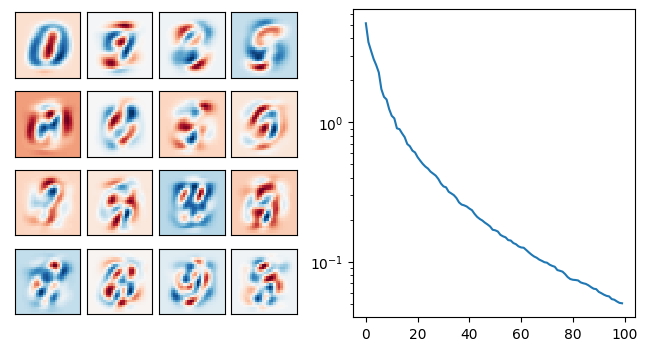

In [33]:
# PCA - learn to recognize these shapes
pca = show_pca(images, 100, fs=(8, 4))

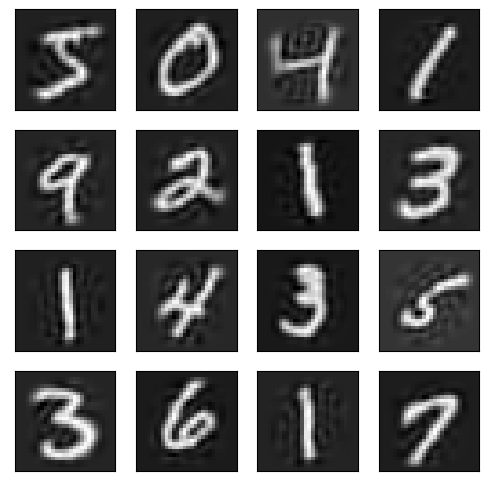

In [35]:
# project onto the transform's subspace then project back
figsize(6, 6)
def tproject(f, inputs):
    return f.inverse_transform(f.transform(inputs))

showgrid(tproject(pca, images))

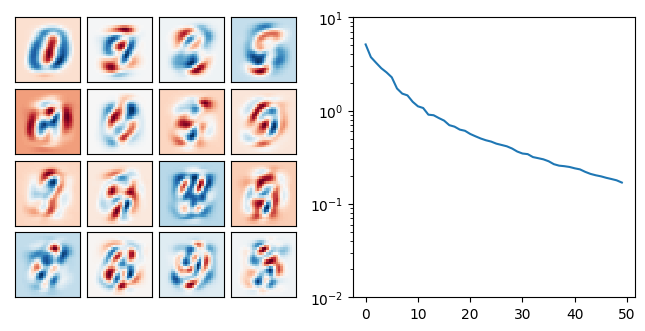

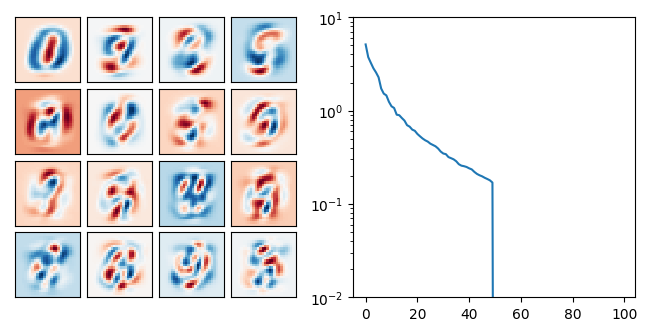

In [36]:
# after a first PCA, the components are "just gone" in a second PCA

figsize(8,8)
pca = show_pca(images, 50, rows=2, row=0, ylim=(1e-2, 1e1))
pca2 = show_pca(tproject(pca, images), 100, rows=2, row=1, ylim=(1e-2, 1e1))

# SUMMARY

PCA finds an optimal (L2 sense) linear subspace for representing the input.

PCA consists of a rotation, a projection, and a measure of variances in each direction.

When data exists in a linear subspace, the variances drop to zero.

# ICA Subspaces

## Independent Component Analysis
    
Find a matrix $W \in \mathbb{R}^{k\times n}$ that is orthonormal $ W W^T = 1 $ that
minimize reconstruction error 

- the components of $W\cdot x$ have minimal mutual information
- the components of $W\cdot x$ are maximally non-Gaussian
- that minimizes $\sum || W\cdot x ||_1$

/home/tmb/tutorials/dl-2022/venv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


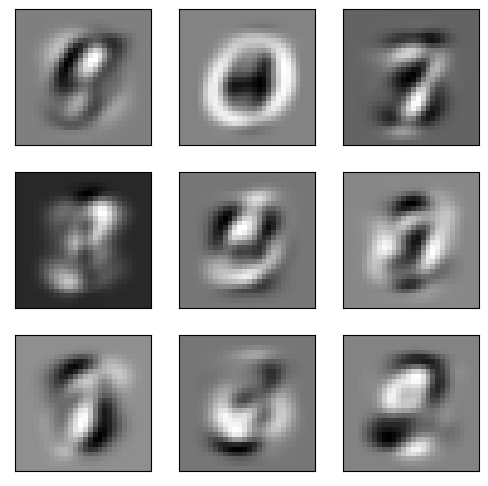

In [37]:
k = 9
ica0 = decomposition.FastICA(k, whiten="arbitrary-variance")
ica0.fit(images.reshape(len(images), -1))
ica0_basis = ica0.inverse_transform(diag(ones(k))).reshape(k, 28, 28)
figsize(6, 6)
showgrid(ica0_basis, 3, 3)

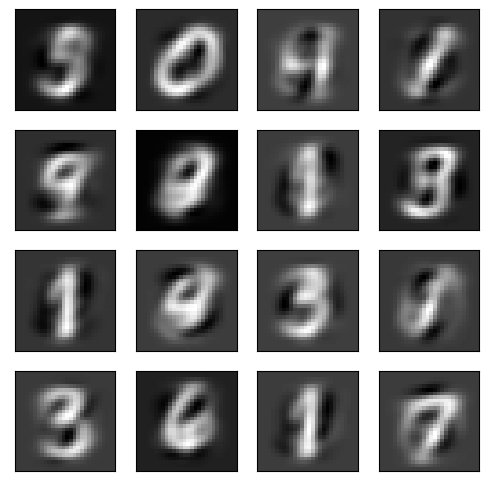

In [38]:
ica0_recon = tproject(ica0, images)
showgrid(ica0_recon)

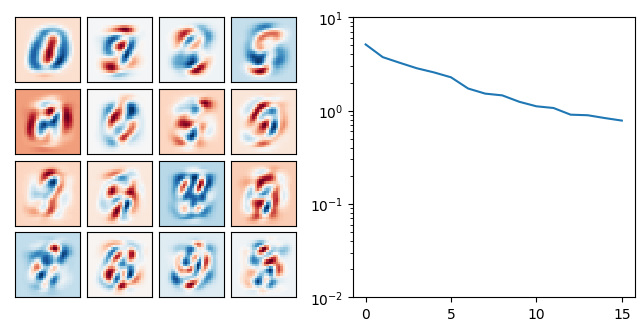

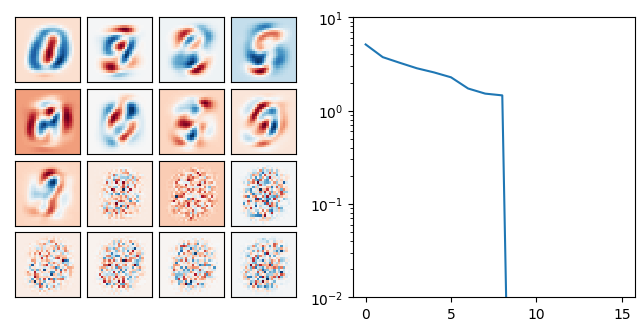

In [39]:
figsize(8,8)
show_pca(images, 16, rows=2, row=0, ylim=(1e-2, 1e1));
show_pca(ica0_recon, 16, rows=2, row=1, ylim=(1e-2, 1e1));

# SUMMARY

ICA finds another low-dimensional subspace, with maximum non-Gaussian components.

The ICA space is still a low-dimensional linear subspace, which shows up in PCA analysis.

# The Cocktail Party Problem

[(784,), (784,), (784,), (784,), (784,), (784,), (784,), (784,), (784,)]


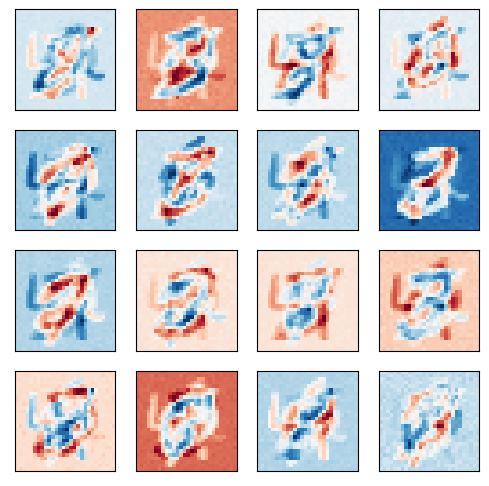

In [41]:
figsize(6, 6)
ncomponents = 9
sources = []
for c in range(ncomponents):
    matching = np.where(classes == c)[0]
    m = int(matching[0])
    sources.append(images[m])
print([s.shape for s in sources])
sources = np.array(sources)    
weights = random.uniform(-1, 1, size=(1000, ncomponents))
mixture = dot(weights, sources)
mixture = mixture + 0.03 * randn(*mixture.shape)
mixture = center_rows(mixture)
showgrid(mixture, cmap=cm.RdBu)


/home/tmb/tutorials/dl-2022/venv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


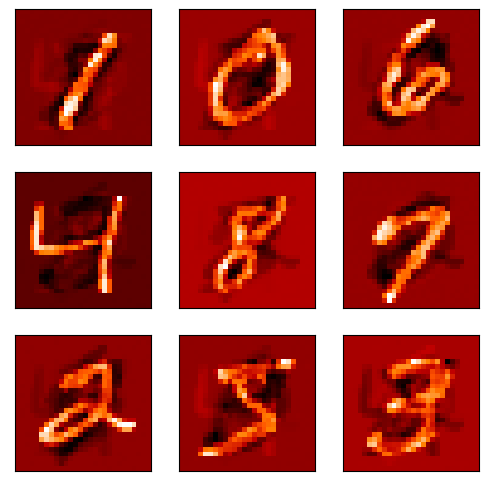

In [42]:
figsize(6, 6)
ica = decomposition.FastICA(ncomponents)
ica.fit(mixture)
for i in range(ncomponents):
    if median(ica.components_[i])>0:
        ica.components_[i] = - ica.components_[i]
showgrid(ica.components_, cmap=cm.gist_heat, rows=3, cols=3)

PCA finds the optimal representation in terms of reconstruction error.

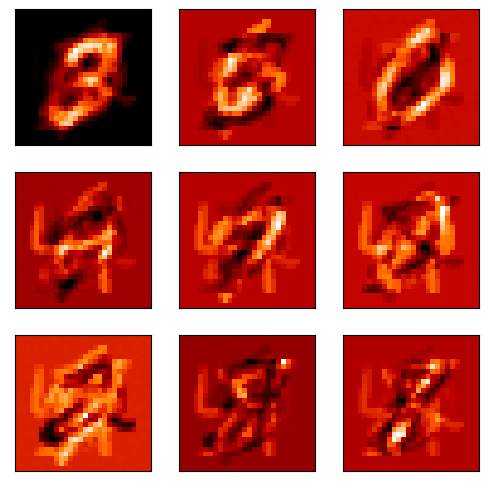

In [43]:
pca = decomposition.PCA(ncomponents)
pca.fit(mixture)
for i in range(ncomponents):
    if median(pca.components_[i])>0:
        pca.components_[i] = - pca.components_[i]
showgrid(pca.components_, cmap=cm.gist_heat, rows=3, cols=3)

# SUMMARY

ICA can separate "mixed sources".

Equivalently, here, each image component has a non-Gaussian (specifically, binomial) distribution.

This can be an important factor in explaining low level feature extraction in images.